In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline

## Carregando e preparando os dados

In [6]:
# carregando os dados
file_path = './alzheimer_disease_dataset/alzheimers_disease_data.csv'
data = pd.read_csv(file_path)

In [7]:
# removendo colunas irrelevantes
data = data.drop(columns=['PatientID', 'DoctorInCharge'])
print(data.columns.tolist())

['Age', 'Gender', 'Ethnicity', 'EducationLevel', 'BMI', 'Smoking', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality', 'SleepQuality', 'FamilyHistoryAlzheimers', 'CardiovascularDisease', 'Diabetes', 'Depression', 'HeadInjury', 'Hypertension', 'SystolicBP', 'DiastolicBP', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL', 'CholesterolTriglycerides', 'MMSE', 'FunctionalAssessment', 'MemoryComplaints', 'BehavioralProblems', 'ADL', 'Confusion', 'Disorientation', 'PersonalityChanges', 'DifficultyCompletingTasks', 'Forgetfulness', 'Diagnosis']


In [11]:
# separando características e alvo
X = data.drop(columns=['Diagnosis']) # recursos -> todas as colunas menos a Diagnosis
y = data['Diagnosis']

# dividindo os dados em treino e em teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# normalizando as características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Validação Cruzada para KNN

Melhor valor de K: 19


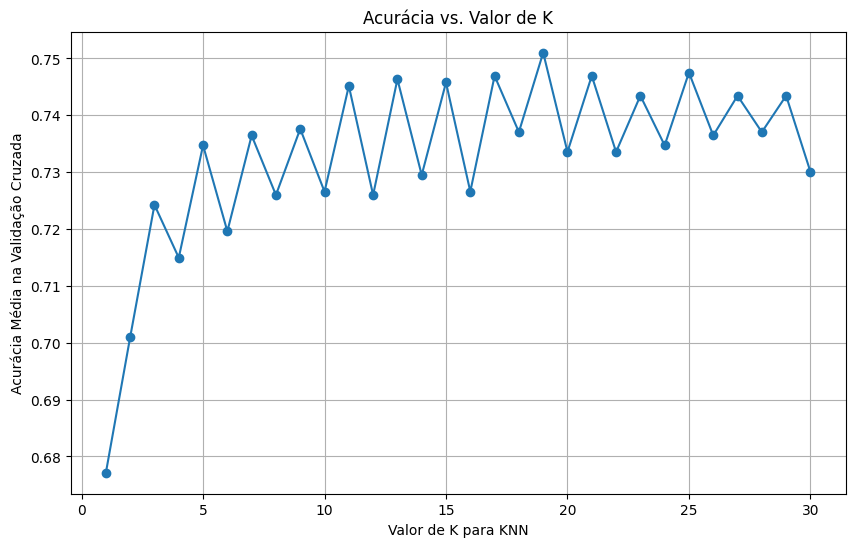

In [20]:
# buscando o melhor valor de k
k_range = range(1, 31)
k_scores = []

for k in k_range:
  knn = KNeighborsClassifier(n_neighbors=k)
  scores = cross_val_score(knn, X_train_scaled, y_train, cv=10, scoring='accuracy')
  k_scores.append(scores.mean())

# encontrando o melhor k
best_k = k_range[np.argmax(k_scores)]
print(f"Melhor valor de K: {best_k}")

plt.figure(figsize=(10, 6))
plt.plot(k_range, k_scores, marker='o')
plt.xlabel('Valor de K para KNN')
plt.ylabel('Acurácia Média na Validação Cruzada')
plt.title('Acurácia vs. Valor de K')
plt.grid(True)
plt.show()

## Treinando o modelo

In [33]:
# treinando o modelo KNN com o melhor k
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train_scaled, y_train)

# avaliando o modelo
accuracy = knn.score(X_test_scaled, y_test)
print(f"Acurácia no conjunto de teste: {accuracy:.2f}")

Acurácia no conjunto de teste: 0.75


## Avaliando o modelo

In [34]:
y_pred = knn.predict(X_test_scaled)

# relatório de classificação e matriz de confusão
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Relatório de Classificação no Modelo KNN:\n", report)
print("Matriz de Confusão no modelo KNN:\n", conf_matrix)

# calculando o Specificity
TN = conf_matrix[0, 0] # true negatives
FP = conf_matrix[0, 1] # false positives
FN = conf_matrix[1, 0] # false negatives
TP = conf_matrix[1, 1] # true positives

specificity = TN / (TN + FP)
print(f"\nSpecificity: {specificity:.2f}")

Relatório de Classificação no Modelo KNN:
               precision    recall  f1-score   support

           0       0.75      0.92      0.83       277
           1       0.76      0.44      0.56       153

    accuracy                           0.75       430
   macro avg       0.76      0.68      0.70       430
weighted avg       0.76      0.75      0.73       430

Matriz de Confusão no modelo KNN:
 [[256  21]
 [ 85  68]]

Specificity: 0.92


## Treinando com as K melhores features

### Selecionando as melhores features

In [24]:
k_best_features = 10

# criando um objeto SelectKBest para selecionar as k melhores features
selector = SelectKBest(score_func=f_classif, k=k_best_features)

X_new = selector.fit_transform(X_train_scaled, y_train)

# exibindo as melhores features
selected_features = X.columns[selector.get_support()]
print(f"As {k} melhores características são:")
print(selected_features)

# ajustando os dados de teste com as mesmas features
X_test_new = selector.transform(X_test_scaled)

As 30 melhores características são:
Index(['EducationLevel', 'SleepQuality', 'SystolicBP', 'DiastolicBP',
       'CholesterolHDL', 'MMSE', 'FunctionalAssessment', 'MemoryComplaints',
       'BehavioralProblems', 'ADL'],
      dtype='object')


### Validação cruzada com as melhores features

Melhor valor de K: 13


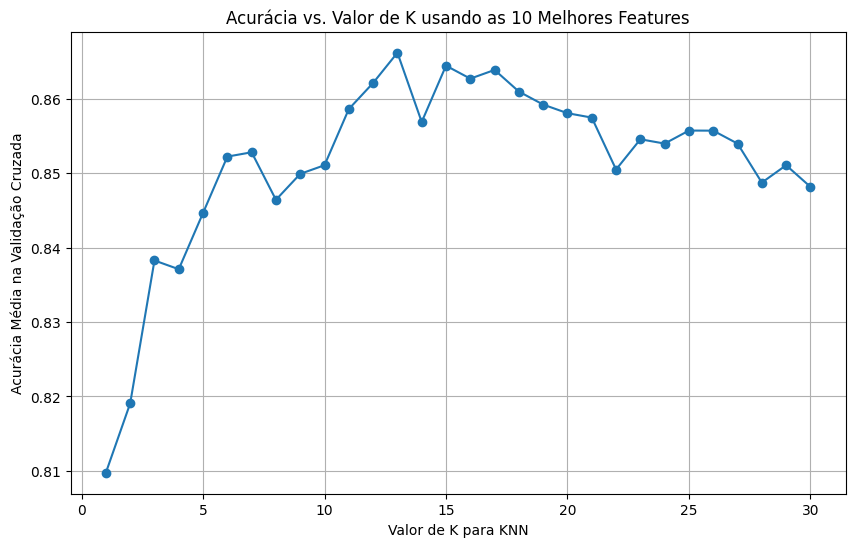

In [25]:
k_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    pipeline = Pipeline([('select', selector), ('knn', knn)])
    scores = cross_val_score(pipeline, X_train_scaled, y_train, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())

# encontrando o melhor k
best_k = k_range[np.argmax(k_scores)]
print(f"Melhor valor de K: {best_k}")

plt.figure(figsize=(10, 6))
plt.plot(k_range, k_scores, marker='o')
plt.xlabel('Valor de K para KNN')
plt.ylabel('Acurácia Média na Validação Cruzada')
plt.title(f'Acurácia vs. Valor de K usando as {k_best_features} Melhores Features')
plt.grid(True)
plt.show()

### Treinando o modelo com as K melhores features

In [32]:
# usando o mehor k encontrado
best_k = k_range[np.argmax(k_scores)]

# treinando o modelo com as melhores features e o melhor k
knn = KNeighborsClassifier(n_neighbors=best_k)
pipeline = Pipeline([('select', selector), ('knn', knn)])
pipeline.fit(X_train_scaled, y_train)

# avaliando o modelo com as melhores features
accuracy = pipeline.score(X_test_scaled, y_test)
print(f"Acurácia no conjunto de teste usando as {k_best_features} melhores features: {accuracy:.2f}\n")

y_pred = pipeline.predict(X_test_scaled)

# relatório de classificação e matriz de confusão
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Relatório de Classificação no Modelo KNN:\n", report)
print("Matriz de Confusão no modelo KNN:\n", conf_matrix)

# calculando o Specificity
TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]

specificity = TN / (TN + FP)
print(f"\nSpecificity: {specificity:.2f}")

Acurácia no conjunto de teste usando as 10 melhores features: 0.87

Relatório de Classificação no Modelo KNN:
               precision    recall  f1-score   support

           0       0.89      0.92      0.90       277
           1       0.85      0.78      0.81       153

    accuracy                           0.87       430
   macro avg       0.87      0.85      0.86       430
weighted avg       0.87      0.87      0.87       430

Matriz de Confusão no modelo KNN:
 [[255  22]
 [ 33 120]]

Specificity: 0.92
